In [1]:
import pandas, re, numpy as np
import datetime ,collections, itertools, random
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import rc

font = {'family': 'DejaVu Sans',
         'weight': 'normal'}
rc('font', **font)

In [ ]:
features = pandas.read_csv('./skydns_stats.csv', header=None, names = ['user_id', 'timestamp', 'tot_reqs', 'denied_reqs'])

Добавим некоторые дополнительные полезные фичи - текущий день недели, час и доля отклонённых запросов

In [3]:
features['deny_rate'] = features['denied_reqs']/features['tot_reqs']
features['hour'] = [ x.split()[1].split(':')[0] for x in features['timestamp']]
features['dow'] = [ datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday() for x in features['timestamp']]

In [32]:
features.head()

,user_id,timestamp,tot_reqs,denied_reqs,deny_rate,hour,dow
0,118785,2014-04-01 00:00:00,289,0,0.000000,00,1
1,58370,2014-04-01 00:00:00,70460,0,0.000000,00,1
2,116231,2014-04-01 00:00:00,2555,6,0.002348,00,1
3,125960,2014-04-01 00:00:00,92,12,0.130435,00,1
4,105230,2014-04-01 00:00:00,168,138,0.821429,00,1


In [9]:
features.to_csv('features.csv', index=False, columns=['user_id', 'timestamp', 'tot_reqs', 'denied_reqs', 'deny_rate','hour', 'dow'])

In [22]:
features = pandas.read_csv('./features.csv')

In [131]:
features.head()

,user_id,timestamp,tot_reqs,denied_reqs,deny_rate,hour,dow
0,118785,2014-04-01 00:00:00,289,0,0.000000,0,1
1,58370,2014-04-01 00:00:00,70460,0,0.000000,0,1
2,116231,2014-04-01 00:00:00,2555,6,0.002348,0,1
3,125960,2014-04-01 00:00:00,92,12,0.130435,0,1
4,105230,2014-04-01 00:00:00,168,138,0.821429,0,1


*********************
Очевидно, что в таком виде данные не представляют особого смысла, потому что информация по пользователям разбросана по файлу, для суждений о том или ином пользователе, нужно всё, что к нему относится, собрать в одном месте

In [93]:
# Среднее количество запросов в час (усредняем по записям, когда траффик был)
grouped_by_user = features.groupby(['user_id'], sort=True)
mean_tot_reqs_per_hour = grouped_by_user['tot_reqs'].mean()

In [119]:
#Средняя доля отклонённых запросов
avg_deny_rate = pandas.DataFrame(
    grouped_by_user['denied_reqs'].sum()/grouped_by_user['tot_reqs'].sum(), columns=['avg_deny_rate']
)

## Обработка по дням недели

Можно утверждать, что предприятия больше запросов производят по будням, чем по выходным

In [23]:
# Group by user and by each day of the week
grouped_by_dow = features.groupby(['user_id', 'dow'], sort=True)
# Produce series - overall request count for each user-day pair
tot_reqs_by_dow = grouped_by_dow['tot_reqs'].sum()

Представим в виде таблицы **Пользователь х День недели** -

Развернём каждый день недели в отдельную колонку, отсутствующие данные будем считать за 0 запросов в этот день

In [53]:
tot_reqs_unstacked_by_dow = tot_reqs_by_dow.groupby(level=0).apply(lambda group: group.unstack(-1)).fillna(0)

In [ ]:
 # Избавимся от дублирующей колонки индекса, получившейся в результате вызова unstack() внутри группировки
tot_reqs_unstacked_by_dow.index = tot_reqs_unstacked_by_dow.index.droplevel()

In [57]:
# Посчитаем в долях, для этого, поделим на сумму по строке
normalized_tot_reqs_unstacked_by_dow = tot_reqs_unstacked_by_dow.div(
    tot_reqs_unstacked_by_dow.sum(axis=1), axis='index'
)

In [58]:
normalized_tot_reqs_unstacked_by_dow.head()

dow,0,1,2,3,4,5,6
user_id,,,,,,,
69,0.162202,0.147520,0.123165,0.143375,0.140715,0.132786,0.150237
86,0.094503,0.158899,0.107472,0.091403,0.118095,0.155474,0.274153
138,0.131356,0.110520,0.103223,0.152985,0.136012,0.175505,0.190398
193,0.000000,0.045455,0.772727,0.000000,0.045455,0.136364,0.000000
196,0.100720,0.082072,0.139589,0.130012,0.052711,0.183666,0.311231


Посчитаем для каждого пользователя долю трафика в выходные от трафика всей недели

In [132]:
weekend_ratio = pandas.DataFrame((normalized_tot_reqs_unstacked_by_dow[5]+normalized_tot_reqs_unstacked_by_dow[6]),
                                 columns=['weekend_ratio'])
weekend_ratio.head()

,weekend_ratio
user_id,
69,0.283023
86,0.429628
138,0.365903
193,0.136364
196,0.494897


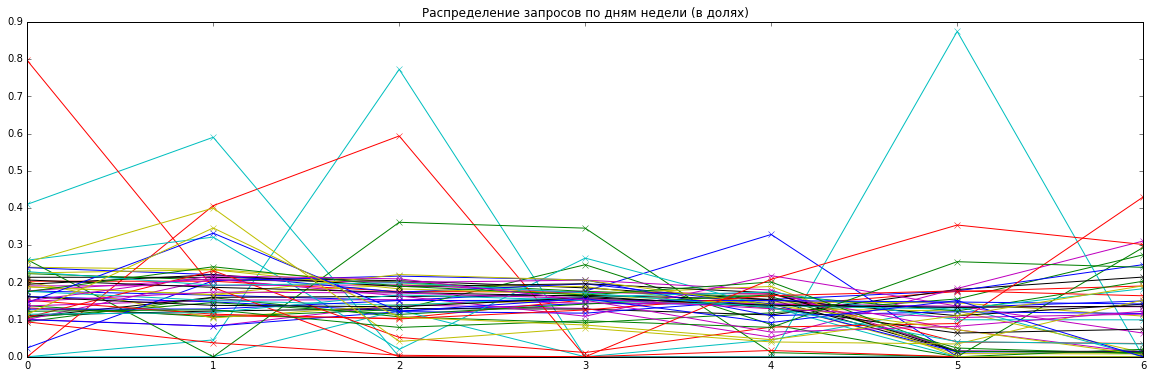

In [68]:
# Можно построить график доли каждого дня недели в структуре всего трафика за неделю
# Видно, что для некоторых пользователей на вызодных наблюдается существенный спад(предположительно, юрлица)
fig, axes = plt.subplots(figsize=(20,6))
axes.set_title('Распределение запросов по дням недели (в долях)')

for data in normalized_tot_reqs_unstacked_by_dow.iloc[0:60,:].iterrows():
    # Не будем рисовать графики с пиками, на которые приходится почти весь недельный трафик
    if data[1].max() > 0.9:
        continue

    axes.plot(
            tot_reqs_unstacked_by_dow.columns,
            (data[1])
        ,marker='x' )

plt.show()
plt.close()

*******************

## То, что связано с майскими праздниками

In [137]:
# Отберём данные с 1 по 10 мая
may_holidays = features.select(\
lambda row_idx: features.iloc[row_idx,:].timestamp.split()[0].split('-')[1]=='05'\
                               and 1<=int(features.iloc[row_idx,:].timestamp.split()[0].split('-')[-1])<=10)

In [5]:
may_holidays = pandas.read_csv('may_holidays.csv')

In [138]:
may_holidays.to_csv('may_holidays.csv')

Посчитаем среднесуточное количество запросов в праздники и по всем дням, чтобы увидеть разницу в потреблении трафика

In [7]:
mean_reqs_per_day_for_holidays = may_holidays.\
select(lambda row_idx: int(may_holidays.loc[row_idx,'timestamp'].split()[0].split('-')[-1]) in [1,2,3,4,9] ).\
groupby('user_id')['tot_reqs'].sum()/5


In [ ]:
mean_reqs_per_day = features.\
groupby(lambda row_idx: (features.loc[row_idx,'user_id'],features.loc[row_idx,'timestamp'].split()[0])
       )['tot_reqs'].sum()

mean_reqs_per_day = mean_reqs_per_day.reindex(pandas.MultiIndex.from_tuples(mean_reqs_per_day.index))
mean_reqs_per_day = mean_reqs_per_day.groupby(level=0).mean()

In [13]:
mean_reqs_per_day_for_holidays = pandas.read_csv('mean_reqs_per_day_for_holidays', index_col='user_id', names=['user_id', 'mean_req'], header=None)

In [ ]:
mean_reqs_per_day_for_holidays.to_csv('mean_reqs_per_day_for_holidays.csv')

In [ ]:
mean_reqs_per_day_for_holidays = pandas.read_csv('mean_reqs_per_day_for_holidays.csv')

In [10]:
mean_reqs_per_day.to_csv('mean_reqs_per_day.csv')

In [11]:
mean_reqs_per_day = pandas.read_csv('mean_reqs_per_day.csv', index_col='user_id', names=['user_id', 'mean_req'], header=None)

Рассчитаем для каждого пользователя соотношение среднего траффика в праздничный день к обычному среднесуточному траффику: очевидно, что для частных лиц такое отношение будет больше 1, а для компаний, который в праздники не работают, - меньше 1, возможно, вообще 0

In [77]:
holiday_ratio = ( mean_reqs_per_day_for_holidays / mean_reqs_per_day).fillna(0)
holiday_ratio.columns = ['holiday_to_avg_mean_reqs_per_day_ratio']

In [78]:
holiday_ratio.head()

,holiday_to_avg_mean_reqs_per_day_ratio
user_id,
69,1.209611
86,0.090165
138,1.053943
193,0.000000
196,0.219008


Сгруппируем информацию по каждому юзеру по каждому дню в период майских праздников с 1 по 10 мая

Представим в виде таблицы **Пользователь х Дата**

In [6]:
grouped_by_day = may_holidays.groupby(lambda row_idx: (may_holidays.loc[row_idx,'user_id'], may_holidays.loc[row_idx,'timestamp'].split()[0]), sort=True)
tot_reqs_by_day = grouped_by_day['tot_reqs'].sum()
tot_reqs_by_day = tot_reqs_by_day.reindex(pandas.MultiIndex.from_tuples(tot_reqs_by_day.index))
tot_reqs_unstacked_by_day = tot_reqs_by_day.groupby(level=0).apply(lambda group: group.unstack(-1)).fillna(0)

Можно посторить график доли запросов за каждый из этих дней, где видно, что промежуточные рабочие дни (5-8 мая) сильно отличаются по потреблению траффика от окружающих праздничных дней

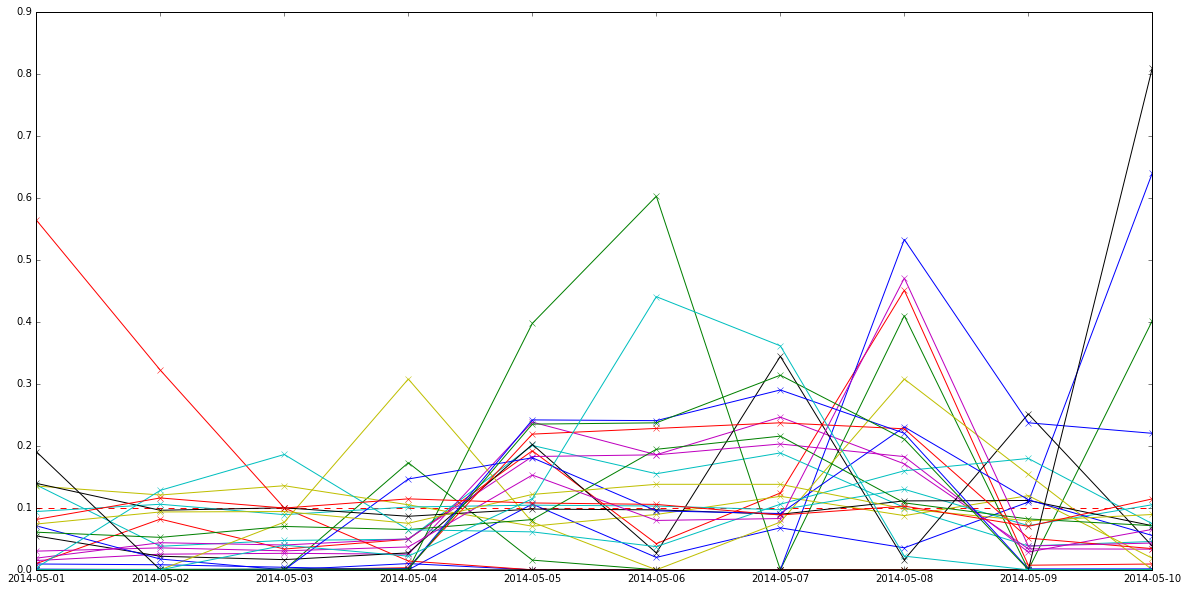

In [201]:
fig, axes = plt.subplots(figsize=(20,10))
axes.set_xticklabels(tot_reqs_unstacked_by_day.columns)
axes.plot(
            ( 1/len(data[1]), )* len(data[1])
        ,'r--')

for idx, data in enumerate(tot_reqs_unstacked_by_day.iloc[60:90,:].iterrows()):
    if ((data[1])/data[1].sum()).max() > 0.9:
        continue
    axes.plot(
            list((data[1])
                            /data[1].sum()
                )
        ,marker='x' )

plt.show()
plt.close()

*************************

## Обработка почасовых профилей

In [79]:
# Group by user and by each hour
grouped_by_hour = features.groupby(['user_id', 'hour'], sort=True)
# Produce series - overall request count for each user-hour pair
tot_reqs_by_hour = grouped_by_hour['tot_reqs'].sum()
# Also for each user-hour pair - mean requests per that hour
mean_reqs_by_hour = grouped_by_hour['tot_reqs'].mean()

In [84]:
# Развернём каждый час в отдельную колонку, отсутствующие данные будем считать за 0 запросов в этот час
tot_reqs_unstacked_by_hour = tot_reqs_by_hour.groupby(level=0).apply(lambda group: group.unstack(-1)).fillna(0)
tot_reqs_unstacked_by_hour.index = tot_reqs_unstacked_by_hour.index.droplevel()

normalized_tot_reqs_unstacked_by_hour = tot_reqs_unstacked_by_hour.div(
    tot_reqs_unstacked_by_hour.sum(axis=1), axis='index'
)

In [87]:
# Unstack mean req count per hour, fill na with 0: no info - no traffic
mean_reqs_unstacked_by_hour = mean_reqs_by_hour.groupby(level=0).apply(lambda group: group.unstack(-1)).fillna(0)
mean_reqs_unstacked_by_hour.index = mean_reqs_unstacked_by_hour.index.droplevel()

Найдём такой час, начиная с которого в течение 8 часов пользователь скачал максимальную долю трафика в сутки. Есть гипотеза, что юрлица имеют структуру трафика, в которой основная доля траффика в сутки приходится на 8-9 часов

In [88]:
def max_for_sliding_window(series, window_width=8, include_subwindow=True):
    max_gain = 0
    subwindow_gain = subwindow_max_gain = 0
    max_gain_start_idx = 0

    for start_idx in range(0, len(series)):
        if  start_idx+window_width > len(series):
            end_idx = (start_idx+window_width) % len(series)
        else:
            end_idx = start_idx+window_width
            
        if start_idx==0:
            gain = series.iloc[start_idx:end_idx].sum()
        else:
            gain -= float(series.iloc[start_idx-1])
            gain += float(series.iloc[end_idx-1])

        if include_subwindow:
            # Проверим, что внутри окна больше 60% не забрали три датапоинта(эвристика)
            # Отсечём этим почасовые профили с острыми короткими пиками
            if start_idx+window_width > len(series):
                window_series = series.iloc[start_idx:].append(series.iloc[:end_idx])
            else:
                window_series = series.iloc[start_idx:end_idx]
            subwindow_gain = max_for_sliding_window(window_series, window_width=3 ,include_subwindow=False).max_gain
            
        if gain > max_gain and (include_subwindow==False or subwindow_gain/gain < 0.6):
            max_gain = gain
            subwindow_max_gain = subwindow_gain
            max_gain_start_idx = start_idx
            
    res = pandas.Series({'max_gain':max_gain,
                          'start_idx': max_gain_start_idx})
    if include_subwindow:
        res['subwindow_max_gain']=subwindow_max_gain
    return res

max_gain = normalized_tot_reqs_unstacked_by_hour.apply(max_for_sliding_window, axis=1)

In [107]:
max_gain.head()

,max_gain,start_idx,subwindow_max_gain
user_id,,,
69,0.620148,15.0,0.317252
86,0.479813,9.0,0.252583
138,0.530775,12.0,0.302041
193,0.090909,21.0,0.045455
196,0.682320,8.0,0.397165


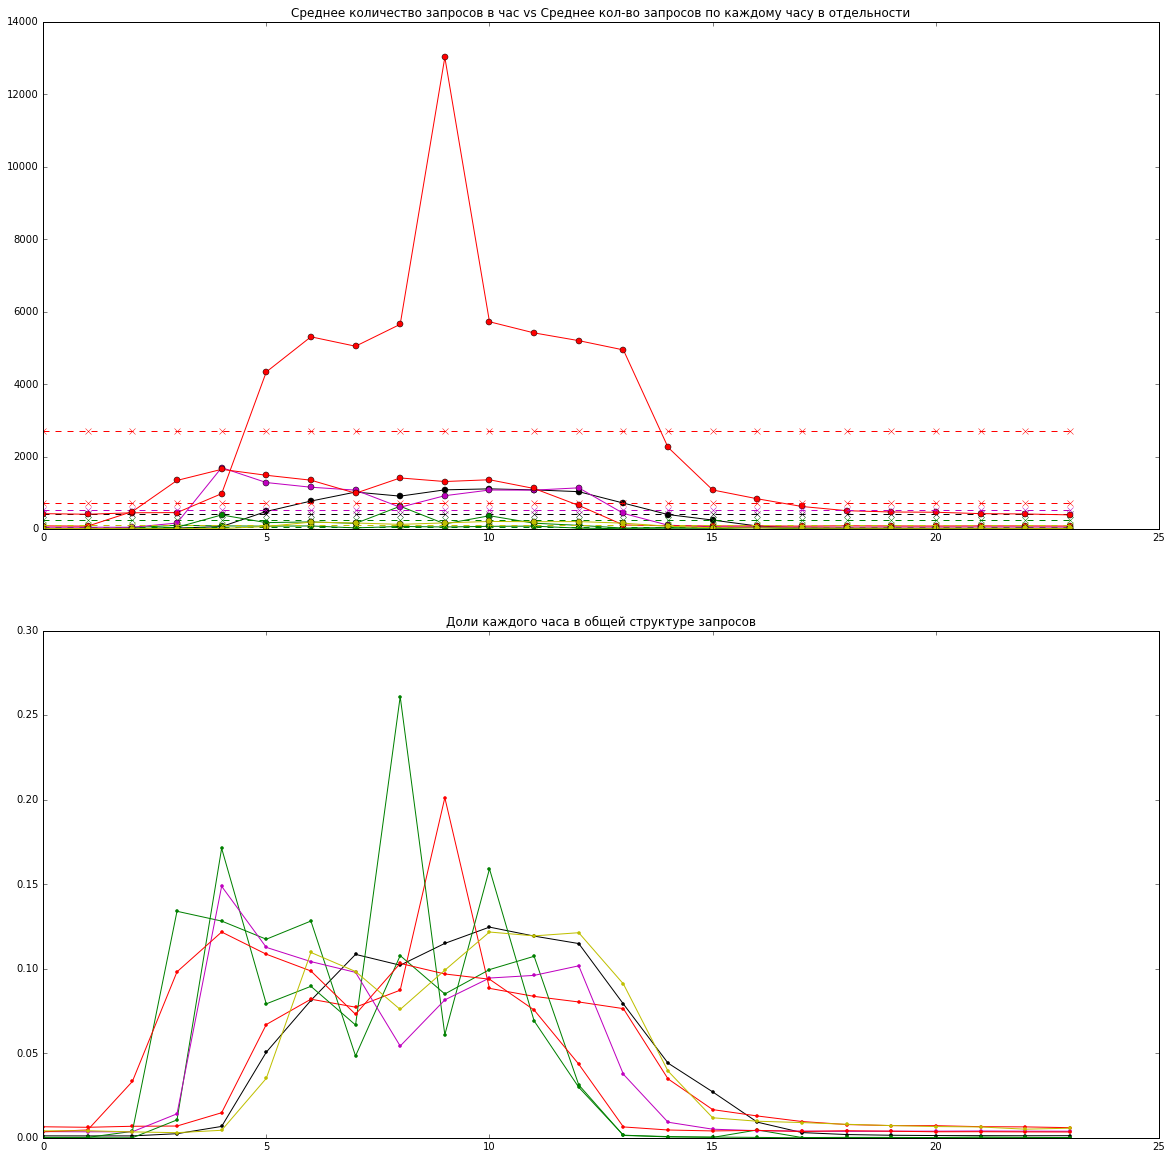

In [96]:
# График средних запросов в час для каждого часа vs средних в час  для каждого пользователя
# + график доли каждого часа в разбивке всего траффика по часам
fig, axes = plt.subplots(nrows=2, figsize=(20,20))

count =0
for data in mean_reqs_unstacked_by_hour.iloc[:30,:].iterrows():
    count +=1
    user_id = data[0]
    
    
#     normalized = tot_reqs_unstacked_by_hour.loc[user_id,:]/tot_reqs_unstacked_by_hour.loc[user_id,:].sum(axis=1).as_matrix()[0]
    if max_gain.loc[user_id, 'max_gain']<0.77:
        continue
    color = 'rgbcmyk'[count % 7]
    axes[0].plot(
            mean_reqs_unstacked_by_hour.columns,
            data[1], 
            '%s' % color
        ,marker='o' )
    axes[0].plot(
            mean_reqs_unstacked_by_hour.columns,
            [mean_tot_reqs_per_hour[user_id]]*24,
            '%s--' % color
        ,marker='x' )
    
    axes[1].plot(
            tot_reqs_unstacked_by_hour.columns,
            normalized_tot_reqs_unstacked_by_hour.loc[user_id,:], 
            '%s' % color
        ,marker='.' )

axes[0].set_title('Среднее количество запросов в час vs Среднее кол-во запросов по каждому часу в отдельности')
axes[1].set_title('Доли каждого часа в общей структуре запросов')
plt.show()
plt.close()

*********************
Собираем все признаки вместе: 
- Максимальная доля восьми часов подряд в структуре траффика за сутки
- Отношения среднесуточного трафика в праздники к среднесуточному трафиику за весь период
- Средний процент отклонённых запросов
- Среднее число запросов в день(логарифмируем, чтоб для больших значений меньше учитывать разницу)
- Доля выходных в структуре траффика за неделю

In [136]:
features_refined = pandas.concat([
        max_gain[['max_gain']].rename(columns={'max_gain': 'max_8_hour_gain'}), 
        holiday_ratio,
        avg_deny_rate,
        np.log(mean_reqs_per_day).rename(columns={'mean_req': 'logged_mean_req_per_day'}),
        weekend_ratio
    ], axis=1)
features_refined.head(10)

,max_8_hour_gain,holiday_to_avg_mean_reqs_per_day_ratio,avg_deny_rate,logged_mean_req_per_day,weekend_ratio
user_id,,,,,
69,0.620148,1.209611,0.000248,7.498797,0.283023
86,0.479813,0.090165,0.007831,7.003252,0.429628
138,0.530775,1.053943,0.122672,6.367131,0.365903
193,0.090909,0.000000,0.000000,1.481605,0.136364
196,0.682320,0.219008,0.007183,6.465987,0.494897
236,0.844690,0.047969,0.193321,9.085512,0.016393
274,0.776370,0.124850,0.007880,11.078041,0.029436
295,0.956765,0.000000,0.043853,7.663037,0.000204
298,0.681656,0.000000,0.047793,6.399510,0.293991


In [137]:
features_refined.to_csv('features_refined.csv')

In [2]:
features_refined = pandas.read_csv('features_refined.csv')

*******************
## Попробуем скластеризовать получившиеся объекты

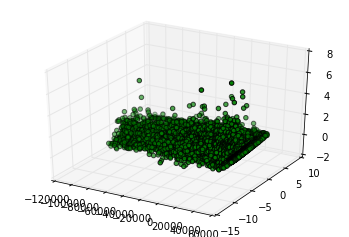

In [14]:
from sklearn.metrics import euclidean_distances
from sklearn import manifold
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
# similarities = euclidean_distances(features_refined)
# mds = manifold.MDS(n_components=2, max_iter=100, eps=1e-9,
#                    dissimilarity="euclidean", n_jobs=2)
# pos = mds.fit(features_refined).embedding_
clf = PCA(n_components=3)
pos = clf.fit_transform(features_refined)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=20, c='g')

In [ ]:
from scipy import linkage, fcluster
from collections import defaultdict
Z = linkage(features_refined, metric='euclidean')

flat_clusters = fcluster(Z, t=0.8, criterion='inconsistent', depth=3) 
clust_content = defaultdict(list)
    for user_idx, clust_idx in enumerate(flat_clusters):
        clust_content[clust_idx-1].append(user_idx)